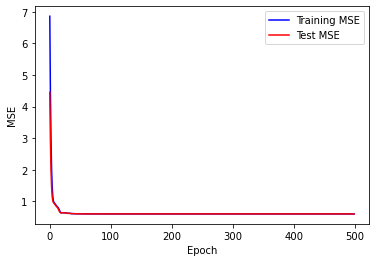

[[21018, 24826, 21863, 24827, 24828, 24829, 24830, 24831, 24832, 24833, 21133, 22789, 21316, 20340, 21386, 20283], [21018, 24826, 21863, 24827, 24828, 24829, 24830, 24831, 24832, 24833, 21133, 22789, 21316, 20340, 21386, 20283], [21018, 24826, 21863, 24827, 24828, 24829, 24830, 24831, 24832, 24833, 21133, 22789, 21316, 20340, 21386, 20283], [21018, 24826, 21863, 24827, 24828, 24829, 24830, 24831, 24832, 24833, 21133, 22789, 21316, 20340, 21386, 20283], [21018, 24826, 21863, 24827, 24828, 24829, 24830, 24831, 24832, 24833, 21133, 22789, 21316, 20340, 21386, 20283], [21018, 24826, 21863, 24827, 24828, 24829, 24830, 24831, 24832, 24833, 21133, 22789, 21316, 20340, 21386, 20283], [21018, 24826, 21863, 24827, 24828, 24829, 24830, 24831, 24832, 24833, 21133, 22789, 21316, 20340, 21386, 20283], [21018, 24826, 21863, 24827, 24828, 24829, 24830, 24831, 24832, 24833, 21133, 22789, 21316, 20340, 21386, 20283], [21018, 24826, 21863, 24827, 24828, 24829, 24830, 24831, 24832, 24833, 21133, 22789, 21

In [8]:
import pandas as pd # 2차원적 자료구조로 dataframe형식으로 데이터를 관리할 수 있다
import torch # 딥러닝 도구로서 2차원 이상의 array로 데이터를 관리할 수 있다
import torch.nn.functional as F # torch에서 제공하는 모듈로 기울기를 쉽게 계산할 수 있다
import pymysql # python에서 SQL명령어를 실행하여 MySQL에 있는 데이터를 받아올 수 있다
from datetime import datetime
import matplotlib.pyplot as plt 
# Kookbob에서 사용중인 서버 goorm ide는 디스플레이가 없는 환경이여서 matplotlib 모듈을 사용한 결과물을 확인할 수 없다. 이로 인해 서버에서는 확인이 불가능하다
# 로컬 파일에서는 matplotlib를 통해 MSE값과 가설을 시각화하여 확인할 수 있다



con = pymysql.connect(
    host='13.209.185.52',
    port=57409,
    user= 'root',
    password='1234',
    db='Kookbob',
    charset='utf8') # mysql connection 연결
cur = con.cursor() # connection으로부터 cursor 생성

reviewSQL = "SELECT user.user_num, review.review_user_id, review.review_menu_id_reviewd, review.menu_name, review.star, review.review_like FROM review INNER JOIN user ON review.review_user_id = user.nickname" 
cur.execute(reviewSQL) # SQL문 실행
rows = cur.fetchall() #SQL 실행 결과값 저장
data = pd.DataFrame(rows) #SQL 실행 결과값 DataFrame화
testData = pd.DataFrame(rows) # testData는 머신러닝이 특정 값에 꽂혀 학습이 불안정해지는 것을 확인하기 위해 필요하다

menus = torch.LongTensor(data[2]) # 리뷰 데이터의 menuId를 받아와 저장
users = torch.LongTensor(data[0]) # 리뷰 데이터의 userNum을 받아와 저장
ratings = torch.FloatTensor(data[4]) # 리뷰 데이터의 별점 값을 받아와 저장
menusTest = torch.LongTensor(testData[2])
usersTest = torch.LongTensor(testData[0])
ratingsTest = torch.FloatTensor(testData[4])


rank = 3 # Latent Vector의 개수. 개수를 늘릴수록 정확도는 높아지나 처리 시간이 길어진다

numMenusSql = "SELECT max(menu_Id) FROM menu;" # menu 테이블에서 menuId가 가장 큰 값을 받아옴.(메뉴 개수를 구하기 위함)
cur.execute(numMenusSql)
numMenuData = cur.fetchall()
numMenuDataFrame = pd.DataFrame(numMenuData)
numMenus = numMenuDataFrame[0].item()+1 # index 문제를 해결하기 위해 +1을 해줌. 0번 인덱스값은 더미 데이터이다.

# numUsersSql = "SELECT max(user_num) FROM user;" # user 테이블에서 userId가 가장 큰 값을 받아옴.(유저 명수를 구하기 위함)
# cur.execute(numUsersSql)
# numUserData = cur.fetchall()
# numUserDataFrame = pd.DataFrame(numUserData)
numUsers = 50 # 50명까지는 처리 가능. 0번 인덱스값은 더미 데이터이다

mean = ratings.mean() # 평균 별점값

lambda1 = 1
lambda2 = 1
lambda3 = 0.5
lambda4 = 0.5 # 원래는 lambda값 역시 여러 가지 경우의 수를 대입하여 가장 정확한 최적의 lambda값을 구해야 하나, 서버 성능의 한계 때문에 처리 시간이 너무 오래 걸려 제거함(더 좋은 서버 구축 시 사용 가능할 듯)


P = torch.randn(numMenus, rank, requires_grad=True) # menu Latent Factor 설정
Q = torch.randn(numUsers, rank, requires_grad=True) # user Latent Factor 설정
biasMenu = torch.randn(numMenus, requires_grad=True) # 정규화를 위한 menu Vector
biasUser = torch.randn(numUsers, requires_grad = True) # 정규화를 위한 user Vecotor 
optim = torch.optim.Adam([P, Q, biasMenu, biasUser], lr = 0.1) # optim.Adam()을 사용하여 머신러닝 구현

for epoch in range(500): # rank와 마찬가지로 시행횟수가 많을수록 정확하나 처리 시간이 길어짐
    h = (P[menus] *Q[users]).sum(dim=1) + mean + biasMenu[menus] + biasUser[users] # 가설
    cost = F.mse_loss(h, ratings) # 비용(MSE)
    loss = cost + lambda1*(P**2).mean() + lambda2*(Q**2).mean() + lambda3*(biasUser**2).mean() + lambda4*(biasMenu**2).mean() # 정규화

    optim.zero_grad()
    loss.backward()
    optim.step() # 모델 업데이트

    with torch.no_grad():
        h_test = (P[menusTest] * Q[usersTest]).sum(dim=1) + mean + biasMenu[menusTest] + biasUser[usersTest]
        cost_test = F.mse_loss(h_test, ratingsTest)

    # with torch.no_grad():
      # if epoch % 100 == 0:
        # print(f"epoch: {epoch}, cost: {cost.item()}, cost_test: {cost_test.item()}\n h:{h}") # 비용(MSE)과 가설의 학습 과정 확인 가능, 이 파일의 출력값이 recommendMenu.js로 넘어가기때문에 평소에는 꺼두어야 한다
        
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.plot(X, Y, c="blue", label = "Training MSE")
plt.plot(X, Y_test, c="red", label = "Test MSE")
plt.legend()
# plt.savefig("Kookbap_MSE.pdf", dpi=300) # 그래프 Kookbap_MSE.pdf로 저장
plt.show()

originalMatrix = torch.transpose(torch.mm(P, torch.transpose(Q,0,1)),0,1)+mean+biasMenu+biasUser.unsqueeze(1) # userId가 x인 사람의 menuId가 y인 메뉴의 예상 별점은 originalMatrix[x][y]와 같다


today = str(datetime.today().year)+"-"+str(datetime.today().month)+"-"+str(datetime.today().day) # 오늘의 날짜
todayMenuSQL = "SELECT * FROM menu INNER JOIN menu_appearance ON menu_appearance.menu_id = menu.menu_id WHERE date = \"{0}\"".format(today) # 오늘의 메뉴를 받아옴
cur.execute(todayMenuSQL)
menuRows = cur.fetchall()
todayMenus = pd.DataFrame(menuRows)
todayMenusId = todayMenus[0] # 오늘의 메뉴 데이터에서 menuId를 받아옴

recommendIndicesArr = []
recommendAll = []

for i in range(numUsers):
    restaurantFilterArr = []
    recommendValues, recommendIndices = torch.sort(originalMatrix[i][todayMenusId], descending=True) # userId가 i인 유저의 todayMenus에 대한 예상 별점들을 내림차순으로 sort하여 정렬한 todayMenusId를 recommendIndices에 저장 
    recommendIndicesArr.append(recommendIndices.tolist())
    for j in range(len(recommendIndicesArr[i])):
        if (todayMenus[1][recommendIndicesArr[i][j]]) == "학생식당" or (todayMenus[1][recommendIndicesArr[i][j]]) == "한울식당" or (todayMenus[1][recommendIndicesArr[i][j]]) == "교직원식당": 
            restaurantFilterArr.append(todayMenus[0][recommendIndicesArr[i][j]]) # 추천 메뉴에 청향, K-BOB+ 등의 메뉴가 들어가는 것은 맞지 않는 것 같아 학생식당, 한울식당, 교직원식당의 메뉴만 추가
        else:
            continue
    recommendAll.append(restaurantFilterArr) # recommendAll은 모든 유저의 오늘의 추천 메뉴를 각각 2차원 배열로 저장한 값이다

print(recommendAll) # recommendAll을 출력하여 recommendMenu.js에서 사용할 수 있게 함

